In [420]:
import random
import torch
import pathlib
import os
import numpy as np
from collections import namedtuple
from torch.utils import data
import PIL
import PIL.Image
import torchvision
from torchvision import transforms

In [2]:
ls1 = [1,2,3,4]
random.sample(ls1, 3)

[4, 2, 3]

In [386]:
%time
pathstr='/data/att_faces'
path = pathlib.Path(pathstr)
files = sorted(list(path.glob("*/*.pgm")))

def files_mapping(files, base_path):
    dirname = []
    filename = []
    dct = {}
    for f in files:
        spl = str(f).split('/')
        dirname = spl[-2]
        filename = spl[-1]

        if dirname not in dct.keys():
            dct.update({dirname:[]})
        else:
            dct[dirname].append(filename)
            dct[dirname]=sorted(dct[dirname])
    return dct


def similar_pair(fmap):
    atp = {}
    c = 0
    for key in fmap.keys():
        atp.update({key:[]})
        n = len(fmap[key])
        ctp = ((n-1)*n)+n
        for i in range(n):
            for j in range(n):
                fp = os.path.join(key, fmap[key][i])
                fo = os.path.join(key, fmap[key][j])
                atp[key].append(((fp,fo),0))
    return atp


def len_similar_pair(fmap):
    dct = {}
    spair = similar_pair(fmap)
    for key in fmap.keys():
        dd = {key:len(spair[key])}
        dct.update(dd)
    return dct


def diff_pair_dircomp(fmap):
    dirname = list(fmap.keys())
    pair_dircomp=[]
    for idx in range(len(dirname)):
        dirtmp = dirname.copy()
        dirtmp.pop(idx)
        odir = dirtmp
        pdir = dirname[idx]
        pdc = (pdir, odir)
        pair_dircomp.append(pdc)
    return pair_dircomp


def different_pair(fmap):
    pair_sampled = {}
    pair_dircomp = diff_pair_dircomp(fmap)
    len_spair = len_similar_pair(fmap)
    for idx, (kp,kvo) in enumerate(pair_dircomp):
        val_pri = fmap[kp]
        num_sample = len(val_pri)//4

        pair_sampled.update({kp:[]})
        for vp in val_pri:
            #get filename file primary
            fp = os.path.join(kp,vp)
            for ko in kvo:
                vov = fmap[ko]
                pair=[]
                for vo in vov:
                    fo = os.path.join(ko,vo)
                    pair.append(((fp, fo),1))
                mout = random.sample(pair,num_sample)
                pair_sampled[kp].append(mout)

    for key in pair_sampled.keys():
        val = pair_sampled[key]
        num_sample =len_spair[key] 
        tmp_val = []
        for va in val:
            for v in va:
                tmp_val.append(v)
        pair_sampled[key] = random.sample(tmp_val,num_sample)
    
    return pair_sampled


def pair_files(base_path, fmap):
    sim_pair = similar_pair(fmap)
    diff_pair = different_pair(fmap)
    files_list = []
    for key in fmap.keys():
        spair = sim_pair[key]
        dpair = diff_pair[key]
        n = len(spair)
        for i in range(n):
            spair_p = os.path.join(base_path,spair[i][0][0])
            spair_o = os.path.join(base_path,spair[i][0][1])
            spair[i] = ((spair_p, spair_o), 0)
            
            dpair_p = os.path.join(base_path, dpair[i][0][0])
            dpair_o = os.path.join(base_path, dpair[i][0][1])
            dpair[i] = ((dpair_p, dpair_o), 1)
            
            files_list.append(spair[i])
            files_list.append(dpair[i])

    return files_list

# pair_files(pathstr, fmap)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


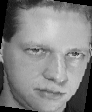

In [437]:
class SiameseDataset(data.Dataset):
    def __init__(self, root, ext, transform=None, pair_transform=None, target_transform=None):
        super(SiameseDataset, self).__init__()
        self.transform = transform
        self.pair_transform = pair_transform
        self.target_transform = target_transform
        self.root = root
        
        self.base_path = pathlib.Path(root)
        self.files = sorted(list(path.glob("*/*."+ext)))
        self.files_map = self._files_mapping()
        self.pair_files = self._pair_files()
        
    def __len__(self):
        return len(self.pair_files)
    
    def __getitem__(self, idx):
        (imp1, imp2), sim = self.pair_files[idx]
        im1 = PIL.Image.open(imp1)
        im2 = PIL.Image.open(imp2)
        
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
        
        if self.pair_transform:
            im1,im2 = self.transform_pair(im1,im2)
            
        if self.target_transform:
            sim = self.target_transform(sim)
        return im1, im2, sim
        
    
    def _files_mapping(self):
        dirname = []
        filename = []
        dct = {}
        for f in self.files:
            spl = str(f).split('/')
            dirname = spl[-2]
            filename = spl[-1]

            if dirname not in dct.keys():
                dct.update({dirname:[]})
            else:
                dct[dirname].append(filename)
                dct[dirname]=sorted(dct[dirname])
        return dct


    def _similar_pair(self):
        fmap = self.files_map
        atp = {}
        c = 0
        for key in fmap.keys():
            atp.update({key:[]})
            n = len(fmap[key])
            ctp = ((n-1)*n)+n
            for i in range(n):
                for j in range(n):
                    fp = os.path.join(key, fmap[key][i])
                    fo = os.path.join(key, fmap[key][j])
                    atp[key].append(((fp,fo),0))
        return atp


    def _len_similar_pair(self):
        fmap = self.files_map
        dct = {}
        spair = self._similar_pair()
        for key in fmap.keys():
            dd = {key:len(spair[key])}
            dct.update(dd)
        return dct


    def _diff_pair_dircomp(self):
        fmap = self.files_map
        dirname = list(fmap.keys())
        pair_dircomp=[]
        for idx in range(len(dirname)):
            dirtmp = dirname.copy()
            dirtmp.pop(idx)
            odir = dirtmp
            pdir = dirname[idx]
            pdc = (pdir, odir)
            pair_dircomp.append(pdc)
        return pair_dircomp


    def _different_pair(self):
        fmap = self.files_map
        pair_sampled = {}
        pair_dircomp = self._diff_pair_dircomp()
        len_spair = self._len_similar_pair()
        for idx, (kp,kvo) in enumerate(pair_dircomp):
            val_pri = fmap[kp]
            num_sample = len(val_pri)//4

            pair_sampled.update({kp:[]})
            for vp in val_pri:
                #get filename file primary
                fp = os.path.join(kp,vp)
                for ko in kvo:
                    vov = fmap[ko]
                    pair=[]
                    for vo in vov:
                        fo = os.path.join(ko,vo)
                        pair.append(((fp, fo),1))
                    mout = random.sample(pair,num_sample)
                    pair_sampled[kp].append(mout)

        for key in pair_sampled.keys():
            val = pair_sampled[key]
            num_sample =len_spair[key] 
            tmp_val = []
            for va in val:
                for v in va:
                    tmp_val.append(v)
            pair_sampled[key] = random.sample(tmp_val,num_sample)

        return pair_sampled


    def _pair_files(self):
        fmap = self.files_map
        base_path = self.root
        sim_pair = self._similar_pair()
        diff_pair = self._different_pair()
        files_list = []
        for key in fmap.keys():
            spair = sim_pair[key]
            dpair = diff_pair[key]
            n = len(spair)
            for i in range(n):
                spair_p = os.path.join(base_path,spair[i][0][0])
                spair_o = os.path.join(base_path,spair[i][0][1])
                spair[i] = ((spair_p, spair_o), 0)

                dpair_p = os.path.join(base_path, dpair[i][0][0])
                dpair_o = os.path.join(base_path, dpair[i][0][1])
                dpair[i] = ((dpair_p, dpair_o), 1)

                files_list.append(spair[i])
                files_list.append(dpair[i])

        return files_list

        

tmft = transforms.Compose([
    transforms.RandomRotation(10),
#     transforms.ToTensor(),
    
])
root='/data/att_faces'
sd = SiameseDataset(root, ext="pgm", transform=tmft)
loader = data.DataLoader(sd, batch_size=32, shuffle=True)
sd.__getitem__(0)[0]
# img1, img2, sim = next(iter(loader))
# img2.shape

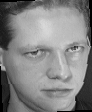

In [438]:
sd.__getitem__(0)[1]

In [342]:
%time


# false_pair_dircompare(fmap)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 21.9 µs


In [346]:



different_pair(fmap)


{'s1': [('s1/7.pgm', 's31/8.pgm'),
  ('s1/10.pgm', 's20/2.pgm'),
  ('s1/7.pgm', 's2/4.pgm'),
  ('s1/6.pgm', 's26/5.pgm'),
  ('s1/9.pgm', 's35/8.pgm'),
  ('s1/9.pgm', 's21/4.pgm'),
  ('s1/10.pgm', 's37/8.pgm'),
  ('s1/3.pgm', 's30/2.pgm'),
  ('s1/9.pgm', 's5/6.pgm'),
  ('s1/6.pgm', 's30/7.pgm'),
  ('s1/5.pgm', 's32/4.pgm'),
  ('s1/2.pgm', 's40/4.pgm'),
  ('s1/8.pgm', 's31/6.pgm'),
  ('s1/10.pgm', 's4/4.pgm'),
  ('s1/6.pgm', 's26/4.pgm'),
  ('s1/6.pgm', 's33/3.pgm'),
  ('s1/10.pgm', 's27/3.pgm'),
  ('s1/7.pgm', 's10/10.pgm'),
  ('s1/4.pgm', 's34/5.pgm'),
  ('s1/9.pgm', 's16/7.pgm'),
  ('s1/6.pgm', 's40/5.pgm'),
  ('s1/9.pgm', 's29/5.pgm'),
  ('s1/3.pgm', 's5/7.pgm'),
  ('s1/7.pgm', 's18/3.pgm'),
  ('s1/6.pgm', 's34/8.pgm'),
  ('s1/9.pgm', 's3/2.pgm'),
  ('s1/10.pgm', 's2/4.pgm'),
  ('s1/8.pgm', 's6/8.pgm'),
  ('s1/9.pgm', 's30/10.pgm'),
  ('s1/6.pgm', 's28/5.pgm'),
  ('s1/3.pgm', 's37/4.pgm'),
  ('s1/2.pgm', 's18/9.pgm'),
  ('s1/2.pgm', 's16/9.pgm'),
  ('s1/10.pgm', 's32/10.pgm'),
  ('s1

In [108]:
all_pair_sampled

[[[('s1/9.pgm', 's9/8.pgm')]],
 [[('s10/9.pgm', 's9/4.pgm')]],
 [[('s11/9.pgm', 's9/10.pgm')]],
 [[('s12/9.pgm', 's9/6.pgm')]],
 [[('s13/9.pgm', 's9/2.pgm')]],
 [[('s14/9.pgm', 's9/10.pgm')]],
 [[('s15/9.pgm', 's9/10.pgm')]],
 [[('s16/9.pgm', 's9/8.pgm')]],
 [[('s17/9.pgm', 's9/10.pgm')]],
 [[('s18/9.pgm', 's9/4.pgm')]],
 [[('s19/9.pgm', 's9/5.pgm')]],
 [[('s2/9.pgm', 's9/6.pgm')]],
 [[('s20/9.pgm', 's9/3.pgm')]],
 [[('s21/9.pgm', 's9/7.pgm')]],
 [[('s22/9.pgm', 's9/10.pgm')]],
 [[('s23/9.pgm', 's9/5.pgm')]],
 [[('s24/9.pgm', 's9/4.pgm')]],
 [[('s25/9.pgm', 's9/3.pgm')]],
 [[('s26/9.pgm', 's9/7.pgm')]],
 [[('s27/9.pgm', 's9/5.pgm')]],
 [[('s28/9.pgm', 's9/6.pgm')]],
 [[('s29/9.pgm', 's9/3.pgm')]],
 [[('s3/9.pgm', 's9/6.pgm')]],
 [[('s30/9.pgm', 's9/7.pgm')]],
 [[('s31/9.pgm', 's9/10.pgm')]],
 [[('s32/9.pgm', 's9/3.pgm')]],
 [[('s33/9.pgm', 's9/4.pgm')]],
 [[('s34/9.pgm', 's9/6.pgm')]],
 [[('s35/9.pgm', 's9/10.pgm')]],
 [[('s36/9.pgm', 's9/7.pgm')]],
 [[('s37/9.pgm', 's9/3.pgm')]],
 [[(

In [27]:
list(fmap.keys())

['s1',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 's16',
 's17',
 's18',
 's19',
 's2',
 's20',
 's21',
 's22',
 's23',
 's24',
 's25',
 's26',
 's27',
 's28',
 's29',
 's3',
 's30',
 's31',
 's32',
 's33',
 's34',
 's35',
 's36',
 's37',
 's38',
 's39',
 's4',
 's40',
 's5',
 's6',
 's7',
 's8',
 's9']